In [1]:
import pygrib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import numpy as np

In [ ]:
# data from https://www.ecmwf.int/en/era5-land
# https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview

# after making an account the data can be fetched using:


# import cdsapi

# c = cdsapi.Client()

# c.retrieve(
#     'reanalysis-era5-land',
#     {
#         'format': 'grib',
#         'variable': '2m_temperature',
#         'year': [
#             '1950', '1951', '1952',
#             '1953', '1954', '1955',
#             '1956', '1957', '1958',
#             '1959', '1960', '1961',
#             '1962', '1963', '1964',
#             '1965', '1966', '1967',
#             '1968', '1969', '1970',
#             '1971', '1972', '1973',
#             '1974', '1975', '1976',
#             '1977', '1978', '1979',
#             '1980', '1981', '1982',
#             '1983', '1984', '1985',
#             '1986', '1987', '1988',
#             '1989', '1990', '1991',
#             '1992', '1993', '1994',
#             '1995', '1996', '1997',
#             '1998', '1999', '2000',
#             '2001', '2002', '2003',
#             '2004', '2005', '2006',
#             '2007', '2008', '2009',
#             '2010', '2011', '2012',
#             '2013', '2014', '2015',
#             '2016', '2017', '2018',
#             '2019', '2020', '2021',
#             '2022',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#         ],
#         'day': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
#             '13', '14', '15',
#             '16', '17', '18',
#             '19', '20', '21',
#             '22', '23', '24',
#             '25', '26', '27',
#             '28', '29', '30',
#             '31',
#         ],
#         'time': '12:00',
#         'area': [
#             47, 13, 42,
#             20,
#         ],
#     },
#     'cro_hourly.grib')


In [2]:
grbs = pygrib.open('cro_hourly.grib')

grb_select = grbs.select()

In [3]:
len(grb_select)

26418

In [4]:
grb_select[0]

1:2 metre temperature:K (instant):regular_ll:surface:level 0:fcst time 12 hrs:from 195001010000

In [5]:
# grb_select[0].keys()

In [6]:
grb = grb_select[0]

In [7]:
for x in ['day', 'month', 'year', 'hour', 'parameterName', 'parameterUnits']:
    print(x, grb[x])

day 1
month 1
year 1950
hour 0
parameterName 2 metre temperature
parameterUnits K


In [8]:
from datetime import datetime

date = datetime(day=grb['day'], month=grb['month'], year=grb['year']).date()

print(date)

1950-01-01


In [9]:
data = np.asarray(grb.values) - 273.15
print(data.shape)

lons = np.linspace(float(grb['longitudeOfFirstGridPointInDegrees']), \
float(grb['longitudeOfLastGridPointInDegrees']), int(grb['Ni']) )

lats = np.linspace(float(grb['latitudeOfFirstGridPointInDegrees']), \
float(grb['latitudeOfLastGridPointInDegrees']), int(grb['Nj']) )

(51, 71)


In [10]:
data[6, 34]

-1.2354492187499773

In [11]:
from scipy import interpolate


In [12]:
city = 'Čakovec'

if city == 'Čakovec':
    location = np.array([46.3897, 16.438]) # cakovec
elif city == 'Zagreb':
    location = np.array([45.8150, 15.9819]) # zagreb
else:
    assert 0
    
dates = []
vals = []

for i in range(len(grb_select)):
    grb = grb_select[i]
    
    data = np.asarray(grb.values) - 273.15
    
    lons = np.linspace(float(grb['longitudeOfFirstGridPointInDegrees']), \
    float(grb['longitudeOfLastGridPointInDegrees']), int(grb['Ni']) )

    lats = np.linspace(float(grb['latitudeOfFirstGridPointInDegrees']), \
    float(grb['latitudeOfLastGridPointInDegrees']), int(grb['Nj']) )

    interpolated_value = interpolate.interpn((lats[::-1], lons), data[::-1, :], location, method='linear')
    
    date = datetime(day=grb['day'], month=grb['month'], year=grb['year']).date()

    vals.append(interpolated_value)
    dates.append(date)   
    

In [13]:
def moving_average(x, w):
    return (np.convolve(np.asarray(x).flatten(), np.ones(w), 'valid') / w)

smoothed_vals = moving_average(vals, 14)

In [14]:
print(len(dates))
print(len(smoothed_vals))

26418
26405


In [15]:
smoothed_vals

array([ 3.10877939,  3.5353221 ,  3.90184077, ..., 14.3041163 ,
       14.45131806, 14.83619617])

In [16]:
data_by_year = {}

for date, temp in zip(dates, vals):
    if date.year not in data_by_year:
        data_by_year[date.year] = []
    
    data_by_year[date.year].append((date, temp))
    


smoothed_data_by_year = {}

for date, temp in zip(dates, smoothed_vals):
    if date.year not in smoothed_data_by_year:
        smoothed_data_by_year[date.year] = []
    
    smoothed_data_by_year[date.year].append((date, temp))
    


1950 365
1955 365
1960 366
1965 365
1970 365
1975 365
1980 366
1985 365
1990 365
1995 365
2000 366
2005 365
2010 365
2015 365
2020 366


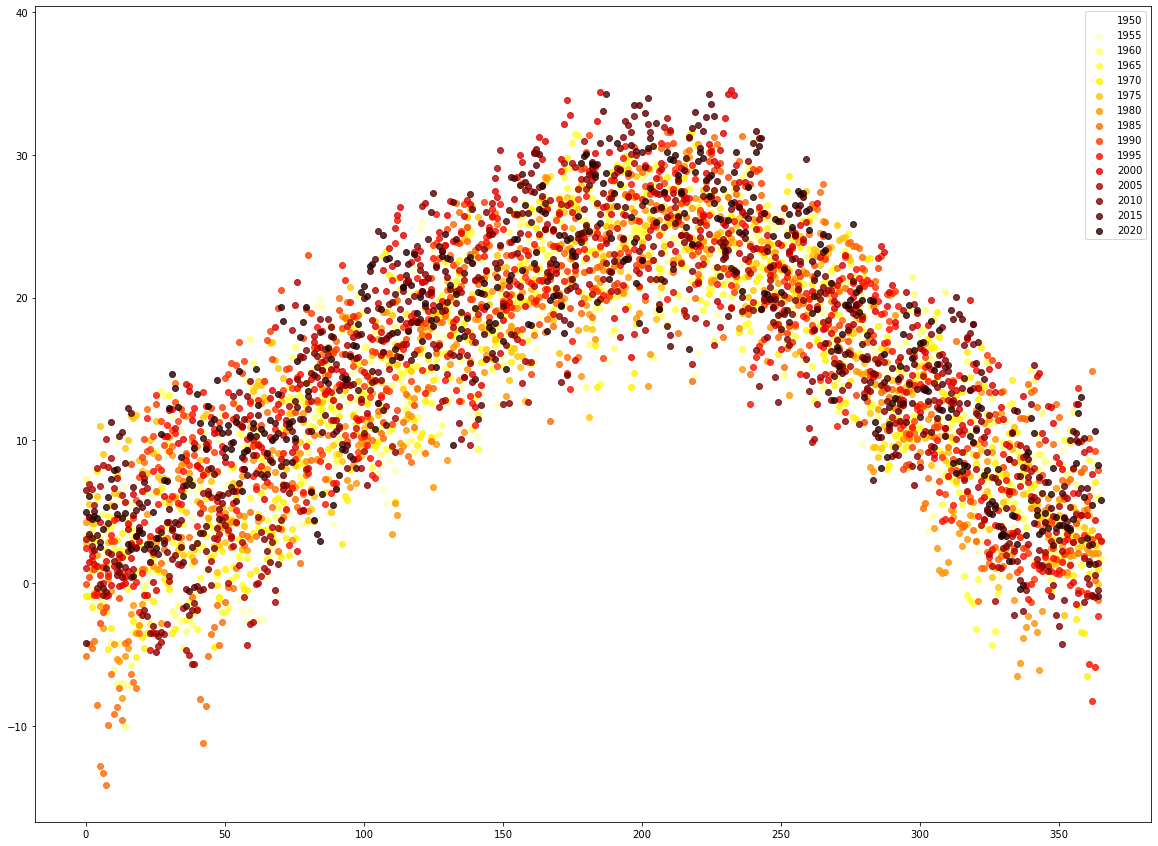

In [17]:
%matplotlib inline

from matplotlib import cm

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

for i, year in enumerate(list(data_by_year.keys())[::5]):
    print(year, len(data_by_year[year]))
    
    ax.scatter(range(len(data_by_year[year])), [x[1] for x in data_by_year[year]], color=cm.hot_r(i / (len(data_by_year) / 5)), label=year, alpha=0.8)
    
    
ax.legend()
    

1950 365
1955 365
1960 366
1965 365
1970 365
1975 365
1980 366
1985 365
1990 365
1995 365
2000 366
2005 365
2010 365
2015 365
2020 366


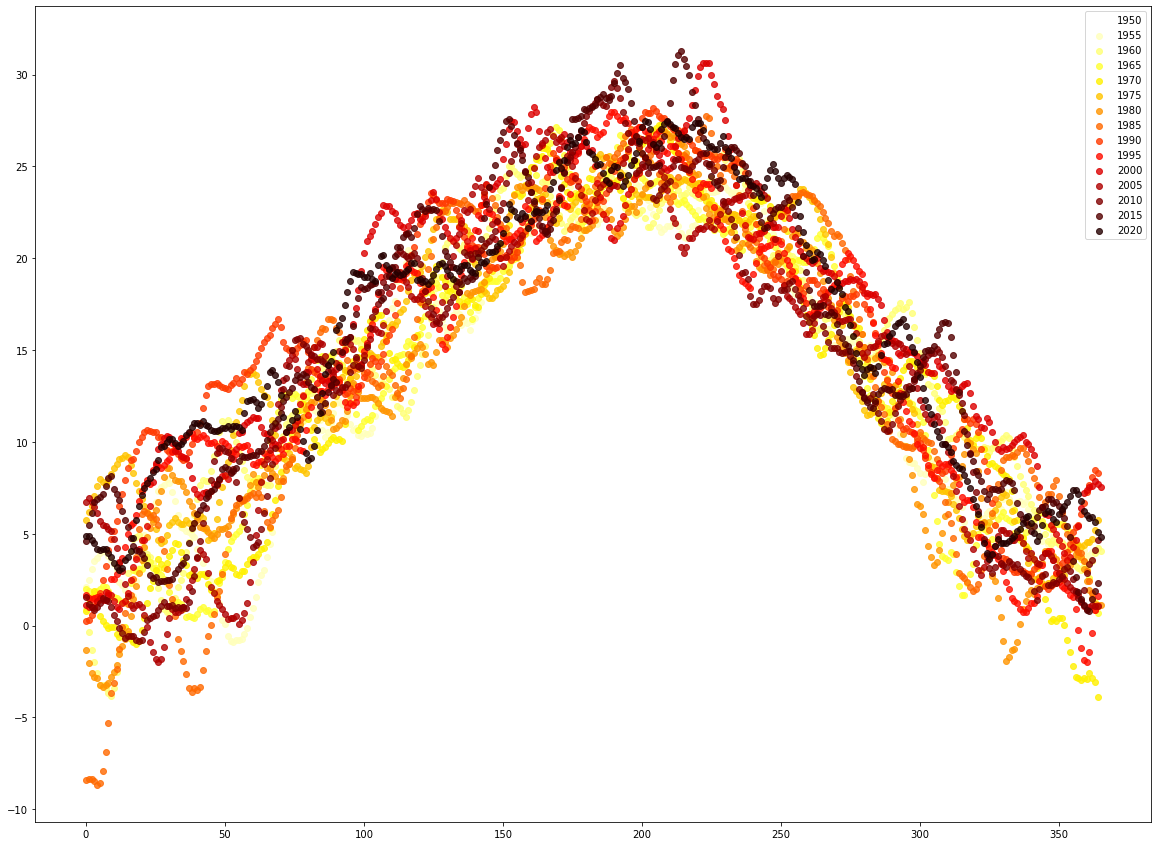

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

for i, year in enumerate(list(smoothed_data_by_year.keys())[::5]):
    print(year, len(smoothed_data_by_year[year]))
    
    ax.scatter(range(len(smoothed_data_by_year[year])), [x[1] for x in smoothed_data_by_year[year]], color=cm.hot_r(i / (len(data_by_year) / 5)), label=year, alpha=0.8)
    
    
ax.legend()

In [19]:
data_by_year_and_month = {}

for date, temp in zip(dates, vals):
    if date.year not in data_by_year_and_month:
        data_by_year_and_month[date.year] = {}
    
    if date.month not in data_by_year_and_month[date.year]:
        data_by_year_and_month[date.year][date.month] = []
    
    data_by_year_and_month[date.year][date.month].append(temp)
    

In [20]:
from scipy.stats import sem


mean_data_by_year_and_month = {}
std_data_by_year_and_month = {}

sem_data_by_year_and_month = {}


for year in data_by_year_and_month.keys():
    mean_data_by_year_and_month[year] = {}
    std_data_by_year_and_month[year] = {}
    sem_data_by_year_and_month[year] = {}
    
    
    for month in data_by_year_and_month[year].keys():
        mean_data_by_year_and_month[year][month] = np.asarray(data_by_year_and_month[year][month]).mean()
        std_data_by_year_and_month[year][month] = np.asarray(data_by_year_and_month[year][month]).std(ddof=1)
        
        sem_data_by_year_and_month[year][month] = sem(np.asarray(data_by_year_and_month[year][month]))


In [21]:
mean_data_by_year_and_month[1950][1]

-0.6640391688192819

In [22]:
from tueplots import bundles

In [23]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

In [24]:
today = datetime.now()

print(datetime.strftime(today, '%d.%m.%Y.'))

05.08.2022.


<ipython-input-25-e74045e7646d>:63: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


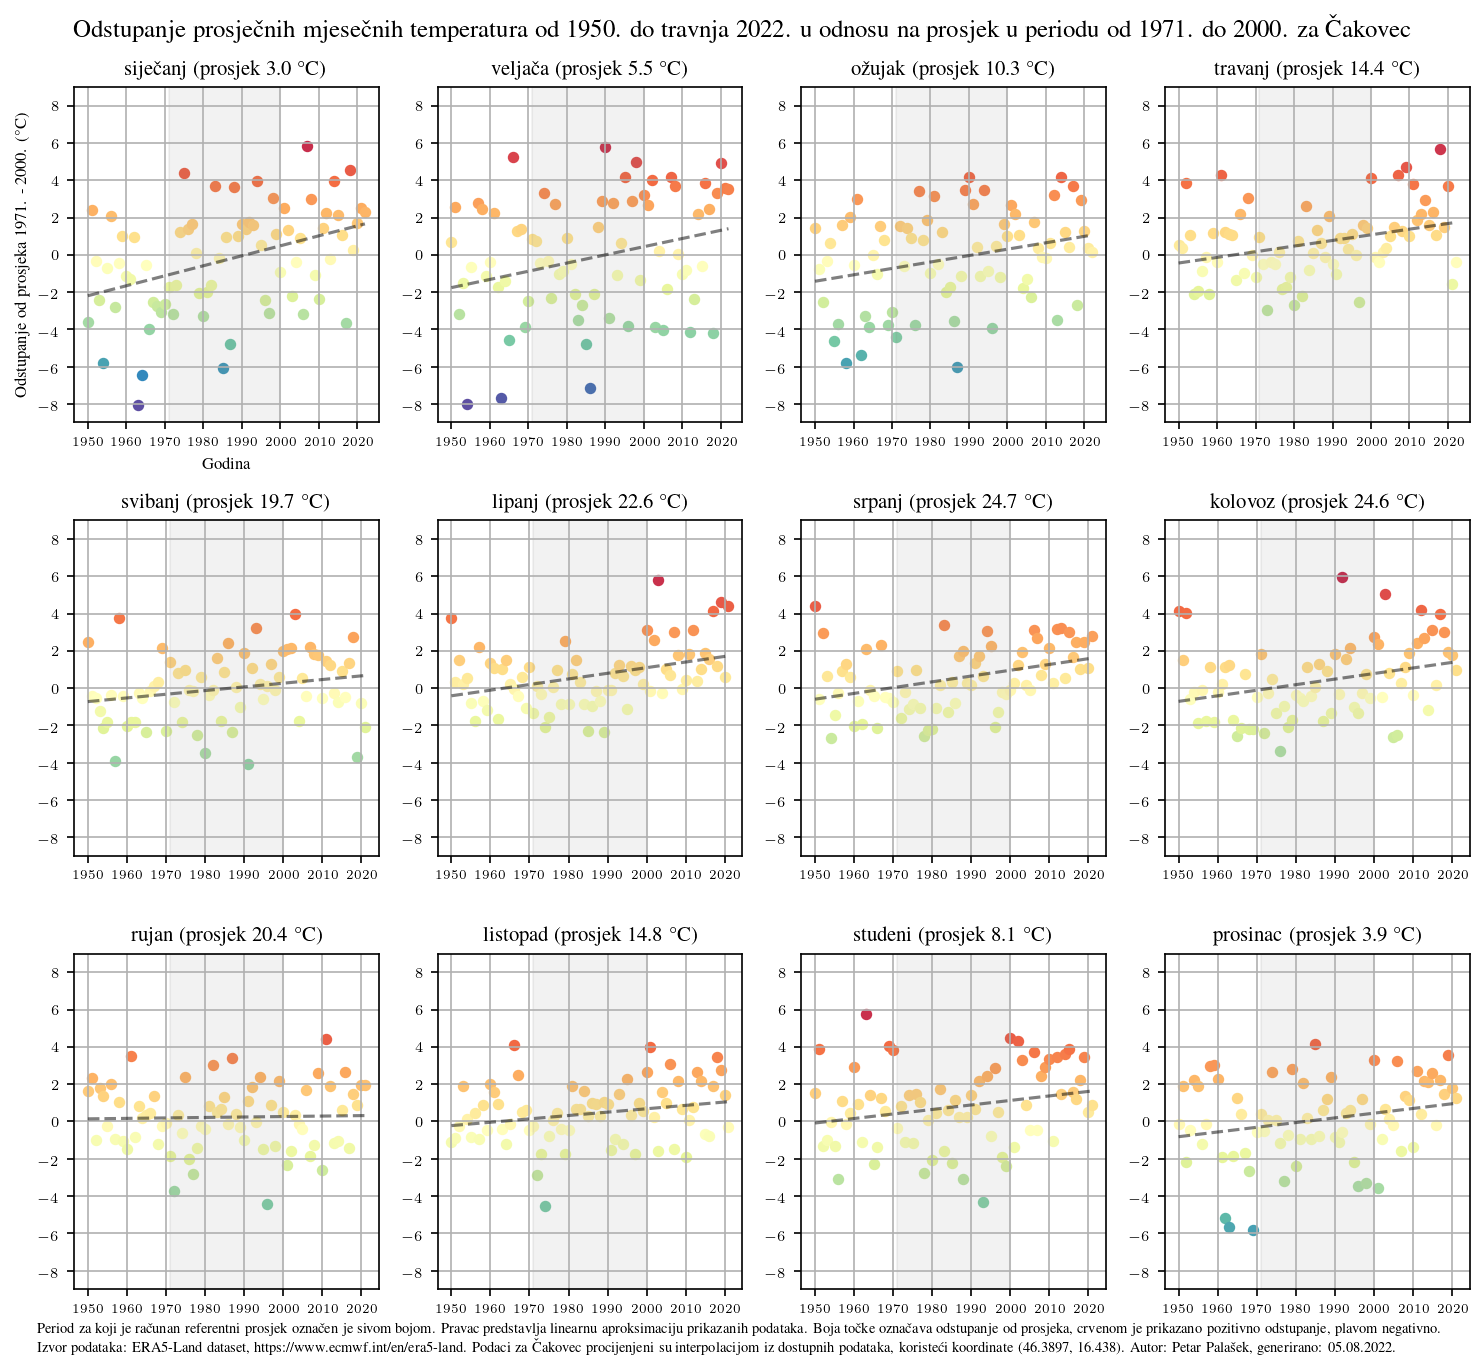

In [25]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update({"font.size": 10})
plt.rcParams.update({"axes.titlesize": 10})

plt.rcParams.update({"xtick.labelsize": 6})
plt.rcParams.update({"ytick.labelsize": 7})

months = ['siječanj', 'veljača', 'ožujak', 'travanj', 'svibanj', 'lipanj', 'srpanj', 'kolovoz', 'rujan', 'listopad', 'studeni', 'prosinac']
 
fig, axs = plt.subplots(3, 4, figsize=(10, 9))

for month in range(1, 13):
    r = (month - 1) // 4
    c = (month - 1) % 4

    all_years = []
    all_years_for_mean = []
    
    
    axs[r, c].grid(True)
    
    for i, year in enumerate(mean_data_by_year_and_month):        
        if month in mean_data_by_year_and_month[year]:
            all_years.append(mean_data_by_year_and_month[year][month])
            
            if year > 1970 and year < 2001:
                all_years_for_mean.append(mean_data_by_year_and_month[year][month])

    all_years_mean = np.asarray(all_years_for_mean).mean()
            
    for i, year in enumerate(mean_data_by_year_and_month):        
        if month in mean_data_by_year_and_month[year]:        
            # axs[r, c].errorbar(year, mean_data_by_year_and_month[year][month] - all_years_mean, yerr=sem_data_by_year_and_month[year][month], color='black', alpha=0.1)
            
            axs[r, c].scatter(year, mean_data_by_year_and_month[year][month] - all_years_mean, color=cm.Spectral_r(((mean_data_by_year_and_month[year][month] - all_years_mean) + 8 )/15), s=20)
        
    x = np.asarray(range(len(all_years)))
                   
    a, b = np.polyfit(x, all_years, 1)
                      
    axs[r, c].plot(x + 1950, a * x + b - all_years_mean, color='black', linestyle='--', alpha=0.5)  


    

    axs[r, c].set_ylim(-9, 9)
    
    if r == 0 and c == 0:
        axs[r, c].set_xlabel('Godina')
        axs[r, c].set_ylabel('Odstupanje od prosjeka 1971. - 2000. (°C)')

    axs[r, c].title.set_text('{} (prosjek {:2.1f} °C)'.format(months[month - 1], all_years_mean))
            
    
    axs[r, c].axvspan(1971, 2000, alpha=0.1, color='gray')

fig.suptitle('Odstupanje prosječnih mjesečnih temperatura od 1950. do travnja 2022. u odnosu na prosjek u periodu od 1971. do 2000. za {}'.format(city))

txt = 'Period za koji je računan referentni prosjek označen je sivom bojom. Pravac predstavlja linearnu aproksimaciju prikazanih podataka. Boja točke označava odstupanje od prosjeka, crvenom je prikazano pozitivno odstupanje, plavom negativno.\nIzvor podataka: ERA5-Land dataset, https://www.ecmwf.int/en/era5-land. Podaci za {} procijenjeni su interpolacijom iz dostupnih podataka, koristeći koordinate ({}, {}). Autor: Petar Palašek, generirano: {}'.format(city, location[0], location[1], datetime.strftime(today, '%d.%m.%Y.'))
plt.figtext(0.03, -0.01, txt, wrap=True, horizontalalignment='left', fontsize=7)

plt.tight_layout()


plt.savefig('image_{}_150.png'.format(city), dpi=150, transparent=False, bbox_inches='tight', facecolor="white")
plt.savefig('image_{}_200.png'.format(city), dpi=200, transparent=False, bbox_inches='tight', facecolor="white")

plt.show()
